## Tutoriel on the Use of Regular Languages to Model Personnel Scheduling Problems

In [1]:
from regular_scheduling.standard_rules import knapsack,cardinality,stretch,pattern
from regular_scheduling.operations import unfold,side,windows,periodic,mask,union,intersection,complementation
from regular_scheduling.tools import show
from regular_scheduling.mip_regular import Regular_Model
from data.parsing import offline,online
from tabulate import tabulate
from time import time

### Automata Theory for Personnel Scheduling

**Example 1 (DFA)**<br>
A representation of a DFA "Pi" recognizing, for example, the words $c,cccc,aba,abba$ but not $ac$ or $ab$ over the alphabet $\{a,b,c\}$.

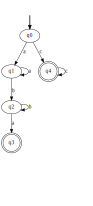

In [2]:
Pi = {"alphabet"         :{"a","b","c"},
      "states"           :{"q0","q1","q2","q3","q4"},
      "initial_state"    :"q0",
      "transitions"      :{("q0","a"):"q1",
                           ("q0","c"):"q4",
                           ("q1","a"):"q1",
                           ("q1","b"):"q2",
                           ("q2","a"):"q3",
                           ("q2","b"):"q2",
                           ("q4","c"):"q4"},
      "accepting_states" :{"q3","q4"}}
show(Pi,scale = 0.5)

**Example 2 (Regular rule and unfolded DFA)**<br>
DFA for the regular rule "*Late* shift is followed by a *Rest* shift" on shifts *Early* ($e$), *Late* ($l$) and *Rest* ($o$) and its unfold version over the sequence of $3$ sets $\left<\{e,l\},\{e,l,o\},\{e,l,o\}\right>$

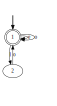

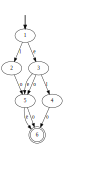

In [3]:
rule = {"alphabet"         :{"e","l","o"},
        "states"           :{1,2},
        "initial_state"    :1,
        "transitions"      :{(1,"e"):1,
                             (1,"l"):2,
                             (1,"o"):1,
                             (2,"o"):1},
        "accepting_states" :{1}}
unfolded = unfold(rule,({"e","l"},{"e","l","o"},{"e","l","o"}))
show(rule,scale = 0.5)
show(unfolded,scale = 0.5)

### Standard Rules

Examples of the $\texttt{cardinality}$, $\texttt{stretch}$ and $\texttt{pattern}$ rules over the $\{a,b\}$ alphabet.

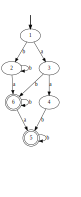

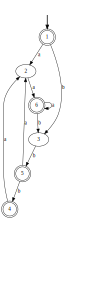

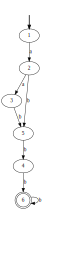

In [4]:
cardinality_rule = cardinality(("a","b"),(1,1),(2,float("inf")))
stretch_rule = stretch(("a","b"),(2,2),(float("inf"),3))
pattern_rule = pattern(("a","b"),"ab",(1,3),(2,float("inf")))

show(cardinality_rule,scale = 0.5)
show(stretch_rule,scale = 0.5)
show(pattern_rule,scale = 0.5)

**Example 3 (Knapsack rule)**<br>
Consider a NSP with three possible shifts: a *Day-off* ($o$), a *Morning* ($m$) shift that lasts $7$ hours and a *Day* ($d$) shift that lasts $10$ hours. The language of $\texttt{knapsack}(\langle o,m,d\rangle,\allowbreak\langle 0,7,10\rangle,\allowbreak 25,\allowbreak 35)$ is the set of schedules whose total working time is at least 25 and at most 35 hours.

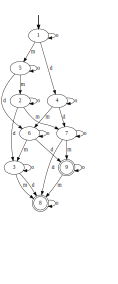

In [5]:
knapsack_rule = knapsack(("m","d","o"),(7,10,0),25,35)
show(knapsack_rule,scale = 0.5)

### Operations

A Factorized $\texttt{stretch}$ rule and the same rule with the side-hypothesis $aa$ on both ends.

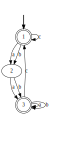

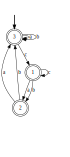

In [6]:
factorized_rule = stretch(({"a","b"},"c"),(2,1),(float("inf"),float("inf")))
side_operation = side(factorized_rule,"aa","aa")
show(factorized_rule,scale = 0.5)
show(side_operation,scale = 0.5)

Example of a rule $\Pi$ ("pattern_union") and $\texttt{windows}(\Pi,2,0,1)$ that bounds its number of occurrences.

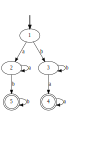

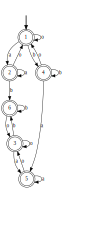

In [7]:
pattern_union = union(pattern(("a","b","o"),"ab"),pattern(("a","b","o"),"ba"))
windows_operation = windows(pattern_union,2,0,1)
show(pattern_union,scale = 0.5)
show(windows_operation,scale = 0.5)

Example of a periodic-composition of a DFA that only accepts the word $ab$ a binary one that forbids consecutive $0$.

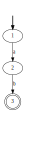

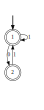

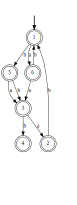

In [8]:
simple_pattern = pattern(("a","b"),"ab",upper_bounds=(1,1))
binary_dfa = stretch(("0","1"),upper_bounds=(1,float("inf")))
periodic_operation = periodic(simple_pattern,2,binary_dfa)
show(simple_pattern,scale=0.5)
show(binary_dfa,scale=0.5)
show(periodic_operation,scale=0.5)

Example of $\texttt{mask}(\Pi,\nu)$ where $\Pi$ ("simple_cardinality") accepts words with exactly one $a$ over the alphabet $\{a,b\}$, and $\nu = 011$ is a mask of length $3$.

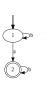

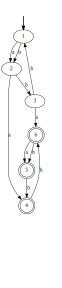

In [9]:
simple_cardinality = cardinality(("a","b"),(1,0),(1,float("inf")))
mask_operation = mask(simple_cardinality,"011")
show(simple_cardinality,scale = 0.5)
show(mask_operation,scale = 0.5)

### Application Example

Some data is not dependent from a planning period but only on general data as possible shifts, labour law (e.g., possible contracts). It is available in amount of an optimization phase. We call this data *offline data*. Here are the notations:

In [10]:
Sigma     = set()
o         = str()
tau       = {s:int() for s in Sigma}
G         = set() 
F         = {g:{s:set() for s in Sigma.difference({o})} for g in G}
gamma_max = {g:int() for g in G}
gamma_min = {g:int() for g in G}
delta_min = {g:int() for g in G}
nu_max    = {g:int() for g in G}
tau_max   = {g:int() for g in G}
rho_max   = {g:{s:int() for s in Sigma.difference({o})} for g in G}

Given this data, it is possible to build DFA representing rules of different contracts.

In [11]:
def regular_rules():
    r = {g:{i:None for i in range(1,8)} for g in G}
    for g in G:
        r[g][1] = windows(union(*[pattern((s,F[g][s],Sigma.difference({s}.union(F[g][s]))),[s,F[g][s]]) for s in Sigma.difference({o})]),2,upper_bound=0)
        r[g][2] = stretch((Sigma.difference({o}),o),upper_bounds = (gamma_max[g],float("inf")))
        r[g][3] = side(stretch((Sigma.difference({o}),o),lower_bounds=(gamma_min[g],1)),[Sigma.difference({o}).copy().pop()]*(gamma_min[g]),[Sigma.difference({o}).copy().pop()]*(gamma_min[g]))
        r[g][4] = side(stretch((Sigma.difference({o}),o),lower_bounds=(1,delta_min[g])),[o]*(delta_min[g]),[o]*(delta_min[g]))
        r[g][5] = mask(periodic(cardinality((Sigma.difference({o}),o),lower_bounds=(1,0)),2,windows(complementation(stretch(("0","1"),upper_bounds=(float("inf"),nu_max[g]))),2,upper_bound=0)),"0000011")
        r[g][6] = periodic(knapsack(tuple(tau.keys()),tuple(tau.values()),upper_bound=tau_max[g]),7)
        r[g][7] = windows(complementation(cardinality(tuple(rho_max[g].keys())+(o,),upper_bounds=tuple(rho_max[g].values())+(float("inf"),))),7,0,0)
    return r

*Online data* is data available at the beginning of the planning period. Their obtaining marks the beginning of the optimization phase. We denote them by:

In [12]:
E   = {g:set() for g in G}
T   = int()
W   = T//7
d   = {t:{s:int() for s in Sigma.difference({o})} for t in range(1,T+1)}
u   = {t:{s:int() for s in Sigma.difference({o})} for t in range(1,T+1)}
v   = {t:{s:int() for s in Sigma.difference({o})} for t in range(1,T+1)}
O   = {e:set() for g in G for e in E[g]}
p   = {e:{t:{s:int() for s in Sigma.difference({o})} for t in range(1,T+1)} for g in G for e in E[g]}
q   = {e:{t:{s:int() for s in Sigma.difference({o})} for t in range(1,T+1)} for g in G for e in E[g]}

When all data is available, it is possible to build different MIP formulations. If we consider preferences or additional days-off, we have to solve a *personalized* problem. We propose the three following formulations:

In [13]:
def ca_mip():

    t0 = time()
    mip = Regular_Model()
    
    # variables
    x = {}
    for g in G:
        for e in E[g]:
            x[e] = mip.binary_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),name = "employee "+e)
    z_minus = mip.continuous_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),lb = 0)
    z_plus = mip.continuous_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),lb = 0)
    y = mip.binary_var_dict((e,w) for e in set().union(*E.values()) for w in range(1,W+1))
    
    # linear constraints
    mip.add_constraints((mip.sum(x[e][t,s] for s in Sigma.difference({o})) <= 1 for e in x.keys() for t in range(1,T+1)),names = "assignments")
    mip.add_constraints((x[e][t,s] == 0 for e in x.keys() for t in O[e] for s in Sigma.difference({o})),names = "days-off") 
    mip.add_constraints((x[e][t,s1]+x[e][t+1,s2] <= 1 for g in G for e in E[g] for t in range(1,T) for s in Sigma.difference({o}) for s1 in Sigma.difference({o}) for s2 in F[g][s1]),names = "rule 1")
    mip.add_constraints((mip.sum(x[e][t2,s] for t2 in range(t1,t1+gamma_max[g]+1) for s in Sigma.difference({o})) <= gamma_max[g] for g in G for e in E[g] for t1 in range(1,T-gamma_max[g]+1)),names = "rule 2")
    mip.add_constraints((mip.sum(x[e][t1,s] for s in Sigma.difference({o})) + (t2 - mip.sum(x[e][t3,s] for t3 in range(t1+1,t1+t2+1) for s in Sigma.difference({o}))) + mip.sum(x[e][t1+t2+1,s] for s in Sigma.difference({o})) >= 1 for g in G for e in E[g] for t2 in range(1,gamma_min[g]) for t1 in range(1,T-t2)),names = "rule 3")
    mip.add_constraints(((1-mip.sum(x[e][t1,s] for s in Sigma.difference({o}))) + mip.sum(x[e][t3,s] for t3 in range(t1+1,t1+t2+1) for s in Sigma.difference({o})) + (1-mip.sum(x[e][t1+t2+1,s] for s in Sigma.difference({o}))) >= 1 for g in G for e in E[g] for t2 in range(1,delta_min[g]) for t1 in range(1,T-t2)),names = "rule 4")
    mip.add_constraints((mip.sum(x[e][t,s] for s in Sigma.difference({o})) <= y[e,w] for e in x.keys() for w in range(1,W+1) for t in [7*w-1,7*w]),names = "rule 5")
    mip.add_constraints((mip.sum(y[e,w] for w in range(w1,w1+2)) <= nu_max[g] for g in G for e in E[g] for w1 in range(1,W)),names = "rule 5'")
    mip.add_constraints((mip.sum(tau[s]*x[e][t,s] for t in range(7*w-6,7*w+1) for s in Sigma.difference({o})) <= tau_max[g] for g in G for e in E[g] for w in range(1,W+1)),names = "rule 6")
    mip.add_constraints((mip.sum(x[e][t2,s] for t2 in range(t1,t1+7)) <= rho_max[g][s] for g in G for e in E[g] for s in Sigma.difference({o}) for t1 in range(1,T-5)),names = "rule 7")
    
    # cover requirements
    mip.add_constraints(mip.sum(x[e_or_g][t,s] for e_or_g in x.keys()) + z_minus[t,s] - z_plus[t,s] == d[t][s] for t in range(1,T+1) for s in Sigma.difference({o}))

    # objective function
    mip.minimize(mip.sum(p[e][t][s]*(1-x[e][t,s]) + q[e][t][s]*x[e][t,s] for e in x.keys() for t in range(1,T+1) for s in Sigma.difference({o})) + mip.sum(z_minus[t,s]*u[t][s]+z_plus[t,s]*v[t][s] for t in range(1,T+1) for s in Sigma.difference({o})))

    mip.building_time = time()-t0
    return mip

def p_rb_mip_prime():

    t0 = time()
    mip = Regular_Model()
    
    # variables
    x = {}
    for g in G:
        for e in E[g]:
            x[e] = mip.binary_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),name = "employee "+e)
    z_minus = mip.continuous_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),lb = 0)
    z_plus = mip.continuous_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),lb = 0)
    y = mip.binary_var_dict((e,w) for e in set().union(*E.values()) for w in range(1,W+1))
    
    # regular constraints
    for g in G:
        for e in E[g]:
            mip.add_regular_constraint(x[e],1,[{o} if t in O[e] else Sigma for t in range(1,T+1)],r[g][1],r[g][2],r[g][3],r[g][4],ctname="flow "+e)
    
    # linear constraints
    mip.add_constraints((mip.sum(x[e][t,s] for s in Sigma.difference({o})) <= y[e,w] for e in x.keys() for w in range(1,W+1) for t in [7*w-1,7*w]),names = "rule 5")
    mip.add_constraints((mip.sum(y[e,w] for w in range(w1,w1+2)) <= nu_max[g] for g in G for e in E[g] for w1 in range(1,W)),names = "rule 5'")
    mip.add_constraints((mip.sum(tau[s]*x[e][t,s] for t in range(7*w-6,7*w+1) for s in Sigma.difference({o})) <= tau_max[g] for g in G for e in E[g] for w in range(1,W+1)),names = "rule 6")
    mip.add_constraints((mip.sum(x[e][t2,s] for t2 in range(t1,t1+7)) <= rho_max[g][s] for g in G for e in E[g] for s in Sigma.difference({o}) for t1 in range(1,T-5)),names = "rule 7")
  
    # cover requirements
    mip.add_constraints(mip.sum(x[e_or_g][t,s] for e_or_g in x.keys()) + z_minus[t,s] - z_plus[t,s] == d[t][s] for t in range(1,T+1) for s in Sigma.difference({o}))

    # objective function
    mip.minimize(mip.sum(p[e][t][s]*(1-x[e][t,s]) + q[e][t][s]*x[e][t,s] for e in x.keys() for t in range(1,T+1) for s in Sigma.difference({o})) + mip.sum(z_minus[t,s]*u[t][s]+z_plus[t,s]*v[t][s] for t in range(1,T+1) for s in Sigma.difference({o})))

    mip.building_time = time()-t0
    return mip

def p_rb_mip():

    t0 = time()    
    mip = Regular_Model()
    
    # variables
    x = {}
    for g in G:
        for e in E[g]:
            x[e] = mip.binary_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),name = "employee "+e)
    z_minus = mip.continuous_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),lb = 0)
    z_plus = mip.continuous_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),lb = 0)
    
    # regular constraints
    for g in G:
        for e in E[g]:
            mip.add_regular_constraint(x[e],1,[{o} if t in O[e] else Sigma for t in range(1,T+1)],*r[g].values(),ctname="flow "+e)
     
    # cover requirements
    mip.add_constraints(mip.sum(x[e_or_g][t,s] for e_or_g in x.keys()) + z_minus[t,s] - z_plus[t,s] == d[t][s] for t in range(1,T+1) for s in Sigma.difference({o}))

    # objective function
    mip.minimize(mip.sum(p[e][t][s]*(1-x[e][t,s]) + q[e][t][s]*x[e][t,s] for e in x.keys() for t in range(1,T+1) for s in Sigma.difference({o})) + mip.sum(z_minus[t,s]*u[t][s]+z_plus[t,s]*v[t][s] for t in range(1,T+1) for s in Sigma.difference({o})))

    mip.building_time = time()-t0
    return mip

Let choose an instance and upload *offline data*.

In [14]:
instance = "./data/Instance1"
locals().update(offline(instance))
print("Offline data are available. E.g., Sigma =",Sigma,"and G =",G)
print("Online data are still unavailable. E.g., T =",T,"and E =",E)

Offline data are available. E.g., Sigma = {'O', 'D'} and G = {'A'}
Online data are still unavailable. E.g., T = 0 and E = {}


We build the differents rules of the possible contracts.

In [15]:
r = regular_rules()

At the beginning of the planning period, we receive *online data* and build a MIP model (or three here in order to later compare them).

In [16]:
locals().update(online(instance,"personalized"))
print("Online data are now available. E.g., T =",T,"and E =",E)

model = {"CA-MIP"   :ca_mip(),
         "P-RB-MIP'":p_rb_mip_prime(),
         "P-RB-MIP" :p_rb_mip()}

Online data are now available. E.g., T = 14 and E = {'A': {'G', 'B', 'F', 'H', 'C', 'A', 'E', 'D'}}


The different models differ in terms of sizes and solving performances.

In [17]:
table = [[k,v.number_of_variables,v.number_of_constraints,round(v.building_time,2),round(v.solve().model.solve_details.time,2)] for k,v in model.items()]
print(tabulate(table, headers=['','Variables','Constraints','Building (s)','Solving (s)']))

print("\nThe minimum cost is",model["P-RB-MIP"].objective_value)
print("\nAn optimal solution is as follow:")
solution = []
for g in G:
    for e in E[g]:
        schedule = model["P-RB-MIP"].get_regular_solution("flow "+e)
        solution.append([e]+schedule[0])
print(tabulate(sorted(solution), headers=['']+list(range(1,T+1)),tablefmt='orgtbl'))

             Variables    Constraints    Building (s)    Solving (s)
---------  -----------  -------------  --------------  -------------
CA-MIP             156            518            0.12           0.3
P-RB-MIP'          844            689            0.09           0.85
P-RB-MIP           951            662            0.11           0.04

The minimum cost is 1110.0

An optimal solution is as follow:
|    | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | 11   | 12   | 13   | 14   |
|----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------|
| A  | O   | D   | D   | D   | D   | O   | O   | D   | D   | O    | O    | D    | D    | O    |
| B  | O   | D   | D   | D   | D   | O   | O   | D   | D   | O    | O    | D    | D    | O    |
| C  | D   | D   | D   | D   | O   | O   | O   | O   | O   | D    | D    | D    | D    | O    |
| D  | D   | D   | O   | O   | O   | D   | D   | D   | D   | D    | O    | O    | O    | O    |
| E  | O   | D   

If we do not consider preferences and additional days-off, we have to solve an *anonymous* version of the problem. It is possible to write an implicit formulation as follow:

In [18]:
def a_rb_mip():
    
    t0 = time()
    mip = Regular_Model()
    
    # variables
    x = {}
    for g in G:
        x[g] = mip.integer_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),lb = 0, ub = len(E[g]), name = "contract "+g)
    z_minus = mip.continuous_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),lb = 0)
    z_plus = mip.continuous_var_dict(((t,s) for t in range(1,T+1) for s in Sigma.difference({o})),lb = 0)
    
    # regular constraints
    for g in G:
        mip.add_regular_constraint(x[g],len(E[g]),T,*r[g].values(),ctname="flow "+g)
     
    # cover requirements
    mip.add_constraints(mip.sum(x[e_or_g][t,s] for e_or_g in x.keys()) + z_minus[t,s] - z_plus[t,s] == d[t][s] for t in range(1,T+1) for s in Sigma.difference({o}))

    # objective function
    mip.minimize(mip.sum(z_minus[t,s]*u[t][s]+z_plus[t,s]*v[t][s] for t in range(1,T+1) for s in Sigma.difference({o})))

    mip.building_time = time()-t0
    return mip

It is still possible to use previous formulation. Comparing them we obtain:

In [19]:
locals().update(online(instance,"anonymous"))

model = {"CA-MIP":ca_mip(),
         "P-RB-MIP'":p_rb_mip_prime(),
         "P-RB-MIP":p_rb_mip(),
         "A-RB-MIP":a_rb_mip()}

table = [[k,v.number_of_variables,v.number_of_constraints,round(v.building_time,2),round(v.solve().model.solve_details.time,2)] for k,v in model.items()]
print(tabulate(table, headers=['','Variables','Constraints','Building (s)','Solving (s)']))

print("\nThe minimum cost is",model["P-RB-MIP"].objective_value)

print("\nAn optimal solution is as follow:")
solution = []
for g in G:
    schedules = model["A-RB-MIP"].get_regular_solution("flow "+g)
    for i,e in enumerate(E[g]):
        solution.append([e]+schedules[i])
print(tabulate(sorted(solution), headers=['']+list(range(1,T+1)),tablefmt='orgtbl'))

             Variables    Constraints    Building (s)    Solving (s)
---------  -----------  -------------  --------------  -------------
CA-MIP             156            510            0.11           0.68
P-RB-MIP'         1116            854            0.06           3.53
P-RB-MIP          1228            830            0.1            0.06
A-RB-MIP           178            116            0.02           0.01

The minimum cost is 1000.0

An optimal solution is as follow:
|    | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | 11   | 12   | 13   | 14   |
|----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+------+------+------|
| A  | D   | D   | D   | D   | O   | O   | O   | D   | D   | O    | O    | O    | D    | D    |
| B  | O   | D   | D   | O   | O   | D   | D   | D   | D   | D    | O    | O    | O    | O    |
| C  | D   | D   | O   | O   | D   | D   | O   | O   | D   | D    | D    | D    | O    | O    |
| D  | D   | D   | D   | D   | O   | O   | 